In [2]:
import gaussianfft
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist
from gaussianfft.util import EmpiricalVariogram
%matplotlib inline
plt.rcParams['figure.figsize'] = [10,7]

In [2]:
# Setup
nx, ny, nz = 200, 200, 1
dx, dy, dz = 20, 20, 20
px, py, pz = 2*nx, 2*ny, 2*nz
v = gaussianfft.variogram('gaussian', 500, 500, 500)
ev = EmpiricalVariogram(v, nx, dx, ny, dy, nz, dz, px, py, pz)

dr = 3 * dx
true_variogram = ev.true_variogram(dr)[1]

# Estimation

Estimating variance could make sense if we also included variance data from each simulation. As of now, it does not.

In [4]:
# Monkey patching for estimation validation (only valid when using origo as reference?)
# ev.simulate = ev.dummy_sim

In [3]:
# refs = ev.pick_reference_points('random', 10, seed=1323)
refs = ev.pick_reference_points('regular', 30)

In [21]:
midpoints, rec_mean, n_samples, tdata, convrg = ev.estimate_variogram(500, dr, refs, analyze_convergence=1)
print('Simulation time: {:.4} (sd: {:.4})'.format(np.mean(tdata['sim']), np.std(tdata['sim'])))
print('Estimation time: {:.4} (sd: {:.4})'.format(np.mean(tdata['est']), np.std(tdata['est'])))

0
50
100
150
200
250
300
350
400
450
Simulation time: 0.07704 (sd: 0.01954)
Estimation time: 0.1352 (sd: 0.05027)


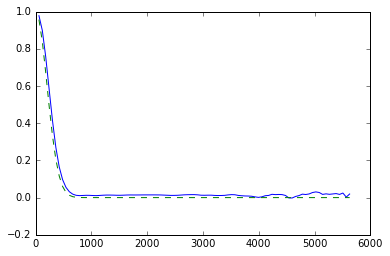

In [22]:
plt.plot(midpoints, rec_mean)
# plt.plot(midpoints, rec_mean + np.sqrt(rec_var), 'r--')
# plt.plot(midpoints, rec_mean - np.sqrt(rec_var), 'r--')
plt.plot(midpoints, true_variogram, 'g--')
plt.show()

<Container object of 93 artists>

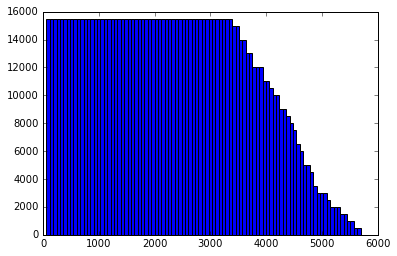

In [23]:
plt.bar(midpoints, n_samples, width=np.diff(midpoints)[0])

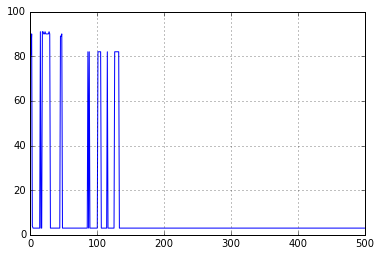

In [27]:
plt.plot(np.abs(np.argmax(convrg.deltas, axis=1)))
plt.grid()

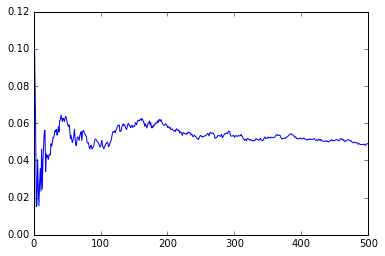

In [38]:
plt.plot(np.abs(convrg.deltas)[:, 6])

## Analysis

EmpiricalVariogram works when there is sufficient padding. For the longest ranges, we may see some artifacts when the padding is large and the variogram range is short. This could simply be caused by a lack of samples, but that may not be the whole story. To verify this, we should try to run an estimation with a huge number of realizations. Another explanation could actually be numerical noise when calculating the mean. How we choose the reference points have not been tested rigorously, but it appears to be convenient to use a number of realizations.

## Ways forward for the EmpiricalVariogram class

- Convergence analysis. We know the true variogram, so we can find, plot and analyze the convergence for each range bin as a function of the number of realizations. This can also be done outside the class, but this may not be as robust (we must at least implement a seeding mechanism). The main purpose of doing this is to identify when we have generated a sufficient number of realizations (for arbitrary input parameters).
- Reference point dependent variogram estimation. It may be of interest to differentiate the variograms estimated in each reference point. For symmetric fields, there should ideally be no difference if the number of realizations is sufficiently high
- Analyze ringing effects. Can we provoke generation of ringing effects, and will the empirical variogram pick up the effect?

# Assessing ringing effects with the empirical variogram

In [21]:
# Setup
nx, ny, nz = 100, 1, 1
dx, dy, dz = 10, 0, 0
pfac = 8.0
px, py, pz = int(pfac*nx), int(pfac*ny), int(pfac*nz)
v = gaussianfft.variogram('gaussian', 1200)

ev = EmpiricalVariogram(v, nx, dx, ny, dy, nz, dz, px, py, pz)

dr = 1.0 * dx
true_variogram = ev.true_variogram(dr)[1]

In [22]:
# refs = ev.pick_reference_points('random', 10, seed=1323)
refs = ev.pick_reference_points('origo')

In [23]:
midpoints, rec_mean, n_samples, tdata, convrg = ev.estimate_variogram(5000, dr, refs, analyze_convergence=10)

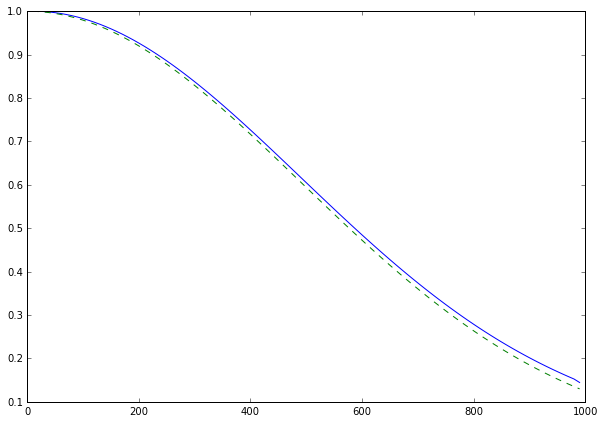

In [24]:
plt.plot(midpoints, rec_mean)
plt.plot(midpoints, true_variogram, 'g--')
plt.show()

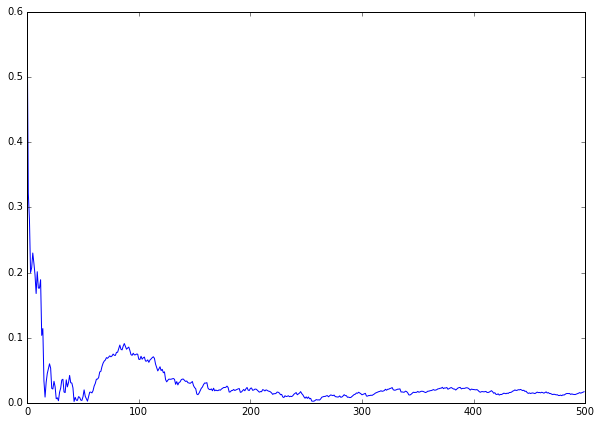

In [25]:
plt.plot(np.abs(convrg.deltas)[:, -5])

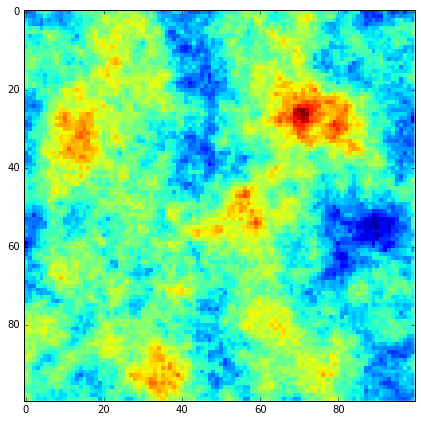

In [202]:
s = ev.simulate()
s_flat = s.reshape((s.shape[0], -1))
plt.imshow(s_flat, interpolation='None')

# Convergence comparison

In [73]:
# Setup
nx, ny, nz = 40, 40, 1
dx, dy, dz = 25, 25, 25
pfac = 1
px, py, pz = int(pfac*nx), int(pfac*ny), int(pfac*nz)
v = gaussianfft.variogram('spherical', 1000, 1000, 1000)

ev1 = EmpiricalVariogram(v, nx, dx, ny, dy, nz, dz, px, py, pz)

dr = 1.5 * dx
true_variogram = ev1.true_variogram(dr)[1]

In [95]:
# Setup 2
pfac = 10
px, py, pz = int(pfac*nx), int(pfac*ny), int(pfac*nz)

ev2 = EmpiricalVariogram(v, nx, dx, ny, dy, nz, dz, px, py, pz)

In [96]:
refs = ev.pick_reference_points('center', 30)
r1 = ev1.estimate_variogram(2000, dr, refs, analyze_convergence=5)
r2 = ev2.estimate_variogram(2000, dr, refs, analyze_convergence=5)

0
50


c:\projects\gaussfft\util\empirical_variogram.py:59: RuntimeWarning: invalid value encountered in true_divide
  local_acc_mean /= local_count


100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950


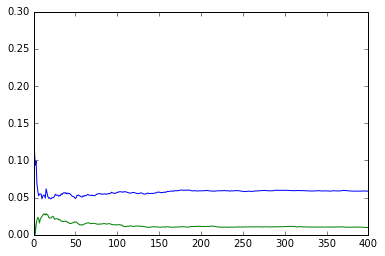

In [97]:
col = 4
plt.plot(np.abs(r1[4].deltas)[:, col])
plt.plot(np.abs(r2[4].deltas)[:, col])

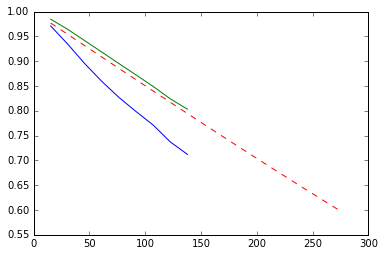

In [98]:
plt.plot(midpoints, r1[1])
plt.plot(midpoints, r2[1])
plt.plot(midpoints, true_variogram, 'r--')
plt.show()

# Padding/Range relationship

In [68]:
desired_range = np.linspace(8, 12, 6)
desired_padding_f = np.arange(1, 11, 2) * 0.5

In [69]:
gaussianfft.seed(12313)
# Setup
L = 1000
n = 40
d = L/n
dr = 1.5*d
vtype = 'gaussian'
nmax = 600

# Convert from aprx pl to exact
output_padding = []  # Actual padding (in number of gridcells)
for p in desired_padding_f:
    output_padding.append(int((p * L)/d))
output_padding_f = np.array(output_padding)/n

# Prepare results
v = gaussianfft.variogram(vtype, desired_range[0] * L, desired_range[0] * L)
ev = EmpiricalVariogram(v, n, d, n, d, 1, 0, output_padding[0], output_padding[0], output_padding[0])
refs = ev.pick_reference_points('origo')
mid, _, _, _, convrg = ev.estimate_variogram(nmax, dr, refs, analyze_convergence=5)
# -----

output_deltas = np.zeros((len(output_padding), len(desired_range), convrg.deltas.shape[1]))
for i, r in enumerate(desired_range):
    print("*** {}/{} ***".format(i, len(desired_range)))
    for j, p in enumerate(output_padding):
        v = gaussianfft.variogram(vtype, r * L, r * L)
        ev = EmpiricalVariogram(v, n, d, n, d, 1, 0, p, p, p)
        refs = ev.pick_reference_points('origo')
        mid, _, _, _, convrg = ev.estimate_variogram(nmax, dr, refs, analyze_convergence=5)
        output_deltas[j, i, :] = convrg.deltas[-1]

output_range = desired_range  # For notational purposes only

*** 0/6 ***
*** 1/6 ***
*** 2/6 ***
*** 3/6 ***
*** 4/6 ***
*** 5/6 ***


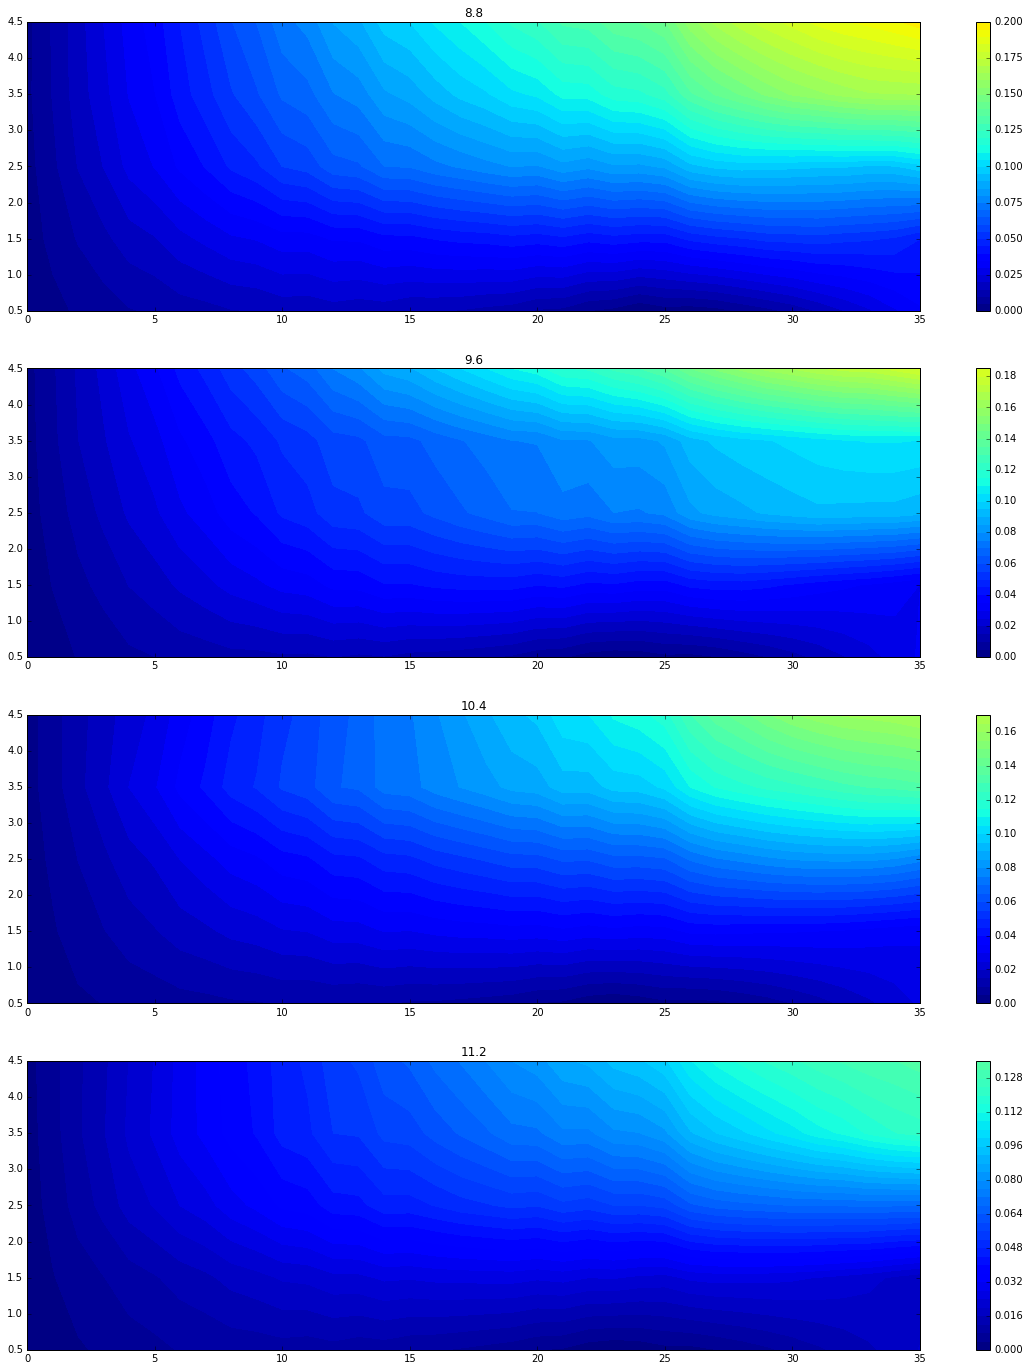

In [71]:
plt.rcParams['figure.figsize'] = [20, 30]
for ir in [1, 2, 3, 4]:
    plt.subplot(510 + ir)
    plt.title(output_range[ir])
    ndelta = output_deltas.shape[2]
    plt.contourf(np.arange(0, ndelta), output_padding_f, np.abs(output_deltas[:, ir, :]), 40, vmax=0.3)
    plt.colorbar()

In [ ]:
res = np.zeros((len(ou), len(rl), 9))
for j in range(output_deltas.shape[0]):
    for i in range(delta_res.shape[1]):
        res[j, i, 0] = np.max(np.abs(delta_res[j, i, :]))                    # Max error
        res[j, i, 1] = np.max(np.abs(delta_res[j, i, :int(0.25*len(mid))]))  # Max error, close
        res[j, i, 2] = np.max(np.abs(delta_res[j, i, :int(0.5*len(mid))]))   # Max error, half way
        res[j, i, 3] = np.mean(np.abs(delta_res[j, i, :]))                   # Mean error
        res[j, i, 4] = np.mean(np.abs(delta_res[j, i, :int(0.25*len(mid))])) # Mean error, close
        res[j, i, 5] = np.mean(np.abs(delta_res[j, i, :int(0.5*len(mid))])  # Mean error, half way
        res[j, i, 6] = np.sum(np.abs(delta_res[j, i, :]))                    # L1 error
        res[j, i, 7] = np.sum(np.abs(delta_res[j, i, :int(0.25*len(mid))]))  # L1 error, close
        res[j, i, 8] = np.sum(np.abs(delta_res[j, i, :int(0.5*len(mid))]))   # L1 error, half way
        

In [54]:
selected_res = res[:, :, 2]

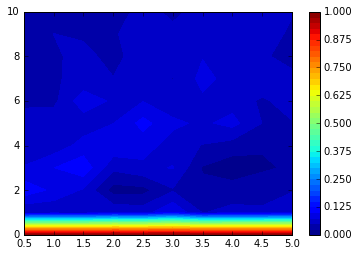

In [55]:
plt.contourf(pl_fraction, rl, selected_res.T, 40)
plt.colorbar()

In [56]:
r = rl[2]
print(r)
p = actual_pl[-1]
v = gaussianfft.variogram(vtype, r * L, r * L)
ev = EmpiricalVariogram(v, n, d, n, d, 1, 0, p, p, p)
mid, evario, _, _, convrg = ev.estimate_variogram(nmax, dr, refs, analyze_convergence=5)

2.0
0
50
100
150
200
250
300
350
400
450
500
550


In [58]:
convrg.deltas.shape

(120, 18)

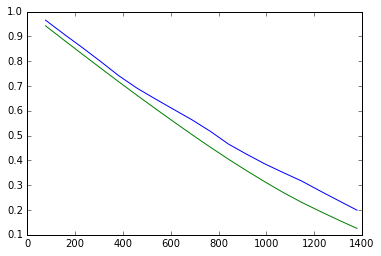

In [57]:
plt.plot(mid, evario)
plt.plot(mid, evario - convrg.deltas[-1, :])

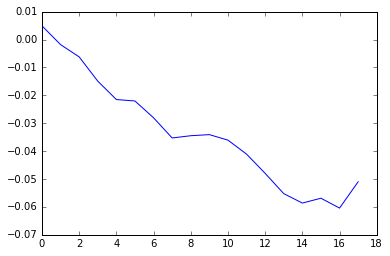

In [51]:
plt.plot(convrg.deltas[-1, :])

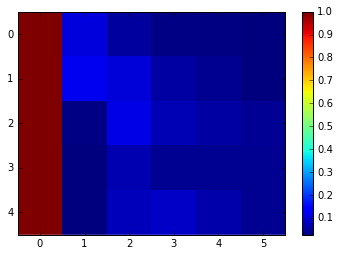

In [11]:
plt.imshow(selected_res, interpolation='None')
plt.colorbar()

In [191]:
from scipy.interpolate import interp2d
finterp = interp2d(pl_fraction, rl, selected_res.T)

In [192]:
nix, niy = 30, 31
gridx = np.linspace(np.min(pl_fraction), np.max(pl_fraction), nix)
gridy = np.linspace(np.min(rl), np.max(rl), niy)
zinterp = np.zeros((nix, niy))
for i, x in enumerate(gridx):
    for j, y in enumerate(gridy):
        zinterp[i, j] = finterp(x, y)

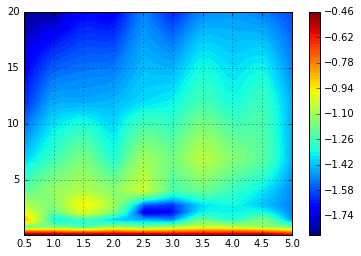

In [197]:
plt.contourf(gridx, gridy, np.log10(zinterp.T), 80)
plt.grid()
plt.colorbar()

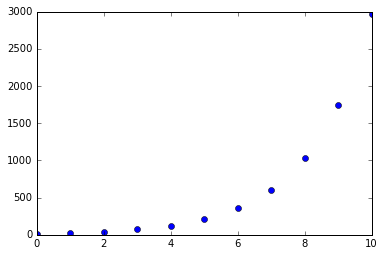

In [165]:
plt.plot(np.exp(5)*rl, 'o')

In [129]:
np.savetxt('res.csv', selected_res, delimiter=',', fmt='%.2f')